In [43]:
import os
import re
import matplotlib.pyplot as plt

current_directory = os.getcwd()
filename = 'ALERT MPK.txt'
filepath = os.path.join(current_directory, filename)

with open(filepath, 'r', encoding='utf-8') as file:
    all_tweets = file.read()

all_tweets = all_tweets.replace("Replying to", "").strip()
all_tweets = all_tweets.replace(" - ", ", ").strip()
all_tweets = all_tweets.replace("(Capitol)", "Capitol").strip()
all_tweets = all_tweets.replace("#AlerMPK", "#AlertMPK").strip()
all_tweets = all_tweets.replace("- ", ", ").strip()
all_tweets = re.sub(r'@AlertMPK\n(?!\·)', '', all_tweets)

lines = all_tweets.split('\n')
non_empty_lines = [line for line in lines if line.strip()]
all_tweets = '\n'.join(non_empty_lines)

tweets = [tweet.strip() for tweet in all_tweets.split('@AlertMPK') if tweet.strip()]

Saving desired tweets as a variable and then cleaning the data. New variable contains only crucial information and is free from any unnecessary parts.

In [44]:
tweets = [tweet for tweet in tweets if len(tweet) >= 28] # irrelevant tweets
tweets_array = []

for item in tweets:
    parts = item.split('\n')
    
    if len(parts) >= 3:
        for index, part in enumerate(parts):
            if len(part) < 7:
                parts[index] += ', 2024' # adding year to the newest tweets
                
        date = parts[1].strip()
        content = ' '.join(parts[2:])
        tweets_array.append([date, content, "-", "-", "-", "-", "-"])


for i, tweet in enumerate(tweets_array, 0): # classifying tweets by the vehicle
    
    if tweets_array[i][1][-12:] == " MPK Wrocław":
        tweets_array[i][1] = tweets_array[i][1][:-12]  
        
    if tweets_array[i][1][:2] == "#A":
        tweets_array[i][1] = tweets_array[i][1][10:]   
        
    if tweets_array[i][1][:2] == "#B":
        tweets_array[i][2] = "BUS"
        tweets_array[i][1] = tweets_array[i][1][5:]
        
        buses_no = re.findall(r"\b(?:[1-9]\d{2}|[ANK|D])\b", tweet[1])   
        if buses_no:
            buses_string = ", ".join(buses_no)
            tweets_array[i][5] = buses_string
            
    elif tweets_array[i][1][:2] == "#T":
        tweets_array[i][2] = "TRAM"
        tweets_array[i][1] = tweets_array[i][1][6:]
        
        trams_no = re.findall(r"(?<!\d:\d\d\b)(?<!:)(?:\b[1-9]\d?|T[1-4])\b(?! Listopada|Maja|Wołyńskiej|Czerwca)(?!\b:\d\d)", tweet[1])
        trams_no = list(set(trams_no))
        if trams_no:
            trams_string = ", ".join(trams_no)
            tweets_array[i][5] = trams_string
        
for i, tweet in enumerate(tweets_array, 0): # 2nd step of classifying tweets
    if tweets_array[i][2] == "-":
        
        if tweets_array[i][1].find("🚍") != -1:
            tweets_array[i][2] = "BUS"
            buses_no = re.findall(r"\b(?:[1-9]\d{2}|[ANK|D])\b", tweet[1])
            
            if buses_no:
                buses_string = ", ".join(buses_no)
                tweets_array[i][5] = buses_string
                
        elif tweets_array[i][1].find("🚋") != -1:
            tweets_array[i][2] = "TRAM"
            trams_no = re.findall(r"(?<!\d:\d\d\b)(?<!:)(?:\b[1-9]\d?|T[1-4])\b(?! Listopada|Maja|Wołyńskiej|Czerwca)(?!\b:\d\d)", tweet[1])
            trams_no = list(set(trams_no))
            if trams_no:
                trams_string = ", ".join(trams_no)
                tweets_array[i][5] = trams_string
            
        else:
            txt_tbc = tweets_array[i][1].lower()
            
            if txt_tbc.find("autobus") != -1:
                tweets_array[i][2] = "BUS"
                
            buses_no = re.findall(r"\b(?:[1-9]\d{2}|[ANK|D])\b", tweet[1])
            
            if buses_no:
                buses_string = ", ".join(buses_no)
                tweets_array[i][5] = buses_string
                
            elif txt_tbc.find("tram") != -1:
                tweets_array[i][2] = "TRAM"
                
                trams_no = re.findall(r"(?<!\d:\d\d\b)(?<!:)(?:\b[1-9]\d?|T[1-4])\b(?! Listopada|Maja|Wołyńskiej|Czerwca)(?!\b:\d\d)", tweet[1])
                trams_no = list(set(trams_no))
                if trams_no:
                    trams_string = ", ".join(trams_no)
                    tweets_array[i][5] = trams_string
                
    if tweet[1][:1] == " ":
        tweet[1] = tweet[1][1:]
    
    if tweets_array[i][1][:1] == "⚠" or tweets_array[i][1][:1] == "⚠️":
        tweets_array[i][3] = "⚠️"
        tweets_array[i][1] = tweets_array[i][1][2:]
        tweet[1] = tweet[1].replace("C.H.", "Centrum Handlowe").strip()
        
        start_index = tweet[1][:75].find("(")
        if start_index != -1:
            end_index = tweet[1].find(")", start_index)
            if end_index != -1:
                tweets_array[i][6] = tweet[1][start_index+1:end_index]
        
        incident = "jazdu"
        position_przejazdu = tweet[1].find(incident)
        
        position_parenthesis = tweet[1].find("(", position_przejazdu)
        position_tram = tweet[1].find("🚋", position_przejazdu)
        position_dot = re.search(r"(?<!\b(?:ul|al|ch|pl|bł|św))\.", tweet[1])
        
        if position_przejazdu != -1 and (position_parenthesis != -1 or position_tram != -1 or position_dot):
            address_end = min_positive = min(val for val in (position_dot.start(), position_tram, position_parenthesis) if val > 0)
            tweet[4] = tweet[1][position_przejazdu + len(incident)+1:address_end].strip()
            tweet[4] = tweet[4].replace("/", ", ").strip()
            
    elif tweets_array[i][1].find("ruch przywr") != -1:
        tweets_array[i][3] = "↩️"
        tweet[4] = tweet[1][:tweets_array[i][1].find("ruch przywr") - 2].strip()
        
    elif tweets_array[i][1].find("wracaj") != -1 or tweets_array[i][1].find("wróc") != -1:
        tweets_array[i][3] = "↩️"
        
    elif (tweets_array[i][1].find("bjazd") != -1 or tweets_array[i][1].find("adyspon") != -1 
          or tweets_array[i][1].find("astępcz") != -1) or tweets_array[i][1].find("kierowan") != -1:
        tweets_array[i][3] = "🔀"   

Organizing tweets by classifying them basing on their attributes. Tweets had been categorized by vehicle, alert type, etc. New array has been filtered and cleaned thus making it ready for structured analysis and interpretation.

1. ↩️ | Feb 29, 2024 | TRAM | - | pętla Poświętne | -
2. ⚠️ | Feb 29, 2024 | TRAM | - | - | -
3. ↩️ | Feb 29, 2024 | TRAM | 14, 1, 15, 16, 8 | - | -
4. - | Feb 29, 2024 | TRAM | 7 | - | -
5. ↩️ | Feb 29, 2024 | TRAM | - | ul. Tarnogajska | -
6. ⚠️ | Feb 29, 2024 | TRAM | 16, 8, 22 | ul. Tarnogajska | wypadek samochodu ciężarowego z tramwajem
7. ↩️ | Feb 29, 2024 | TRAM | - | ul. Łokietka | -
8. ⚠️ | Feb 29, 2024 | TRAM | 14, 7, 15 | ul. Łokietka | awaria tramwaju
9. ⚠️ | Feb 29, 2024 | TRAM | 14, 7, 15 | ul. Łokietka | awaria tramwaju
10. ↩️ | Feb 28, 2024 | TRAM | - | ul. Szewska | -
11. ⚠️ | Feb 28, 2024 | TRAM | 6, 7 | ul. Szewska | kolizja tramwaju z samochodem osobowym
12. ↩️ | Feb 27, 2024 | TRAM | - | rondo Reagana, peron IV | -
13. ⚠️ | Feb 27, 2024 | TRAM | 2, 10 | rondo Reagana, peron IV | awaria autobusu
14. 🔀 | Feb 27, 2024 | BUS | - | - | -
15. ↩️ | Feb 27, 2024 | TRAM | - | ul. Ślężna | -
16. ⚠️ | Feb 27, 2024 | TRAM | 15, 9 | ul. Ślężna | akcja Służb
17. ↩️ | Feb 27, 202

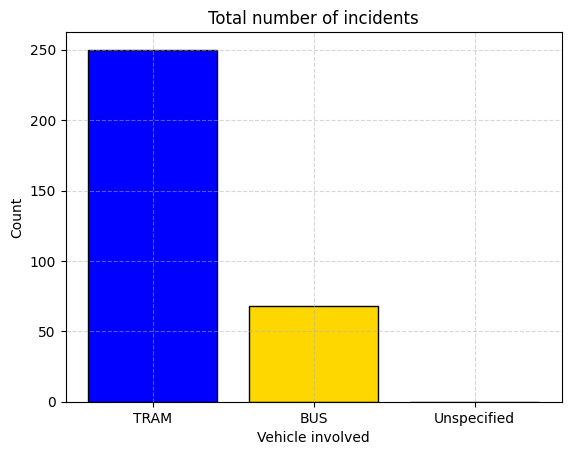

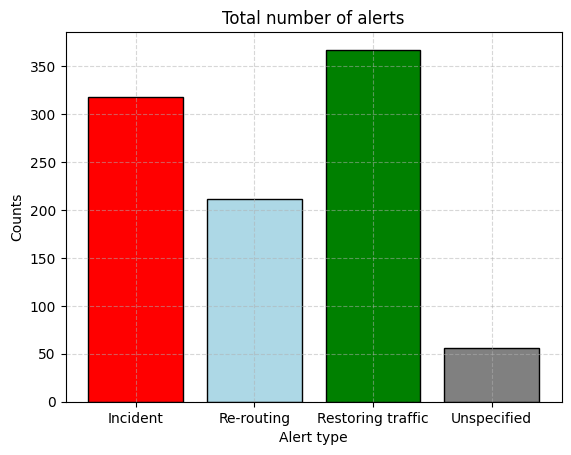

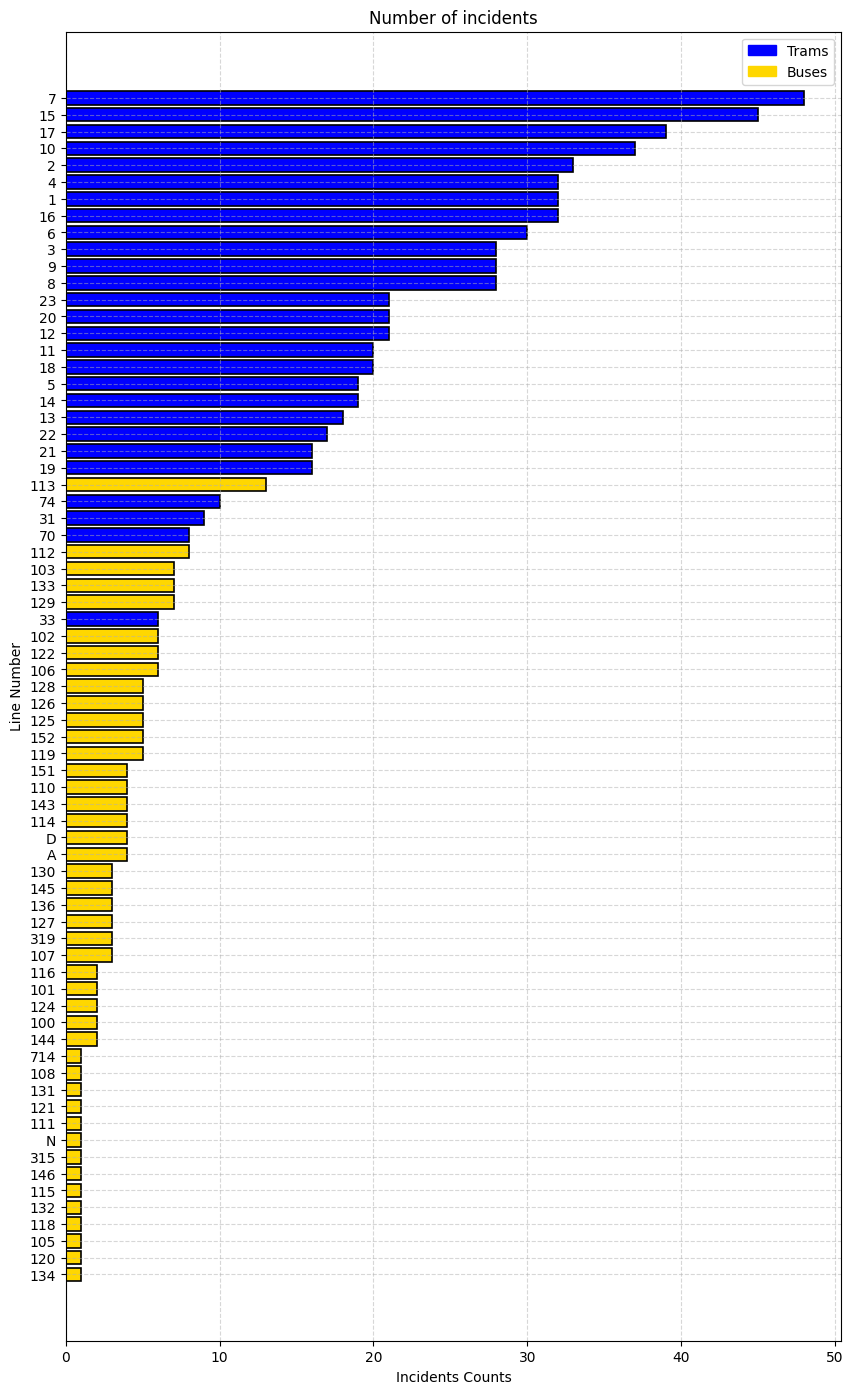

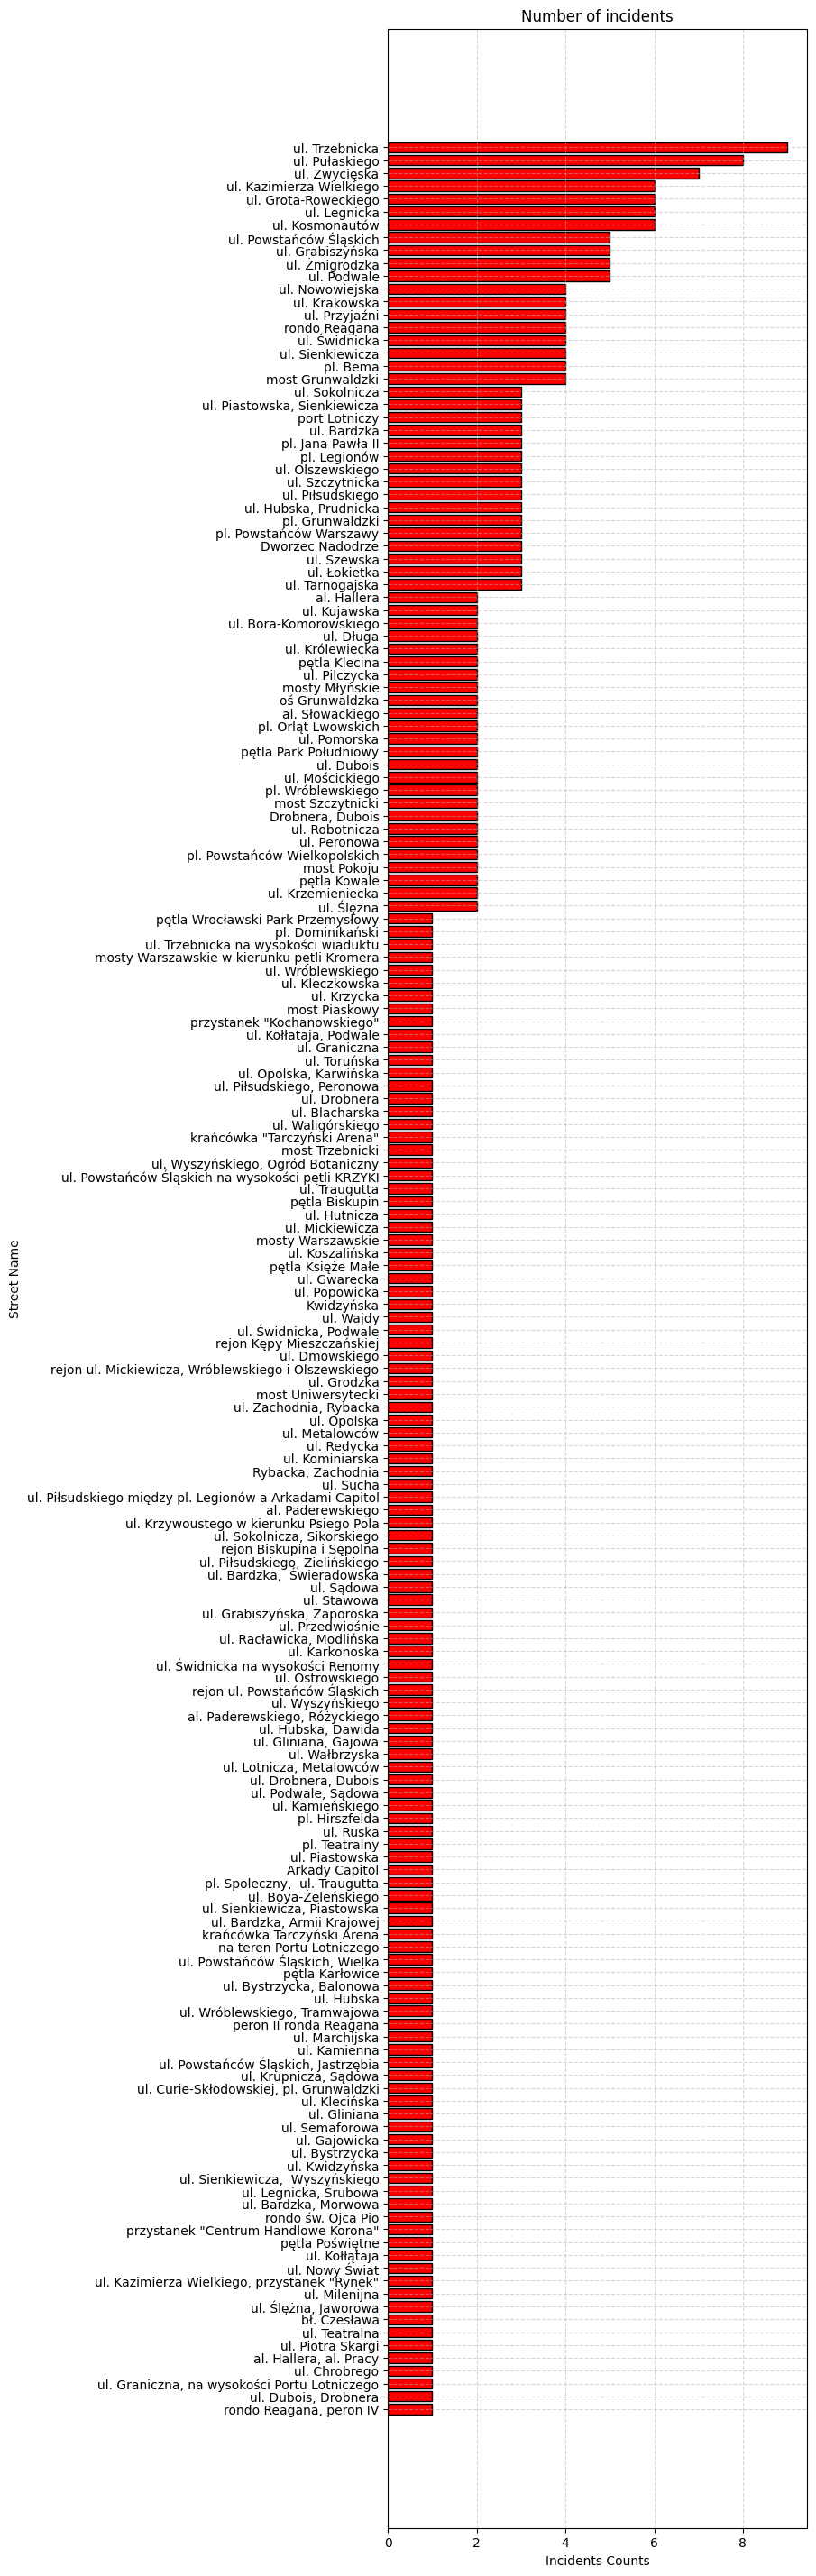

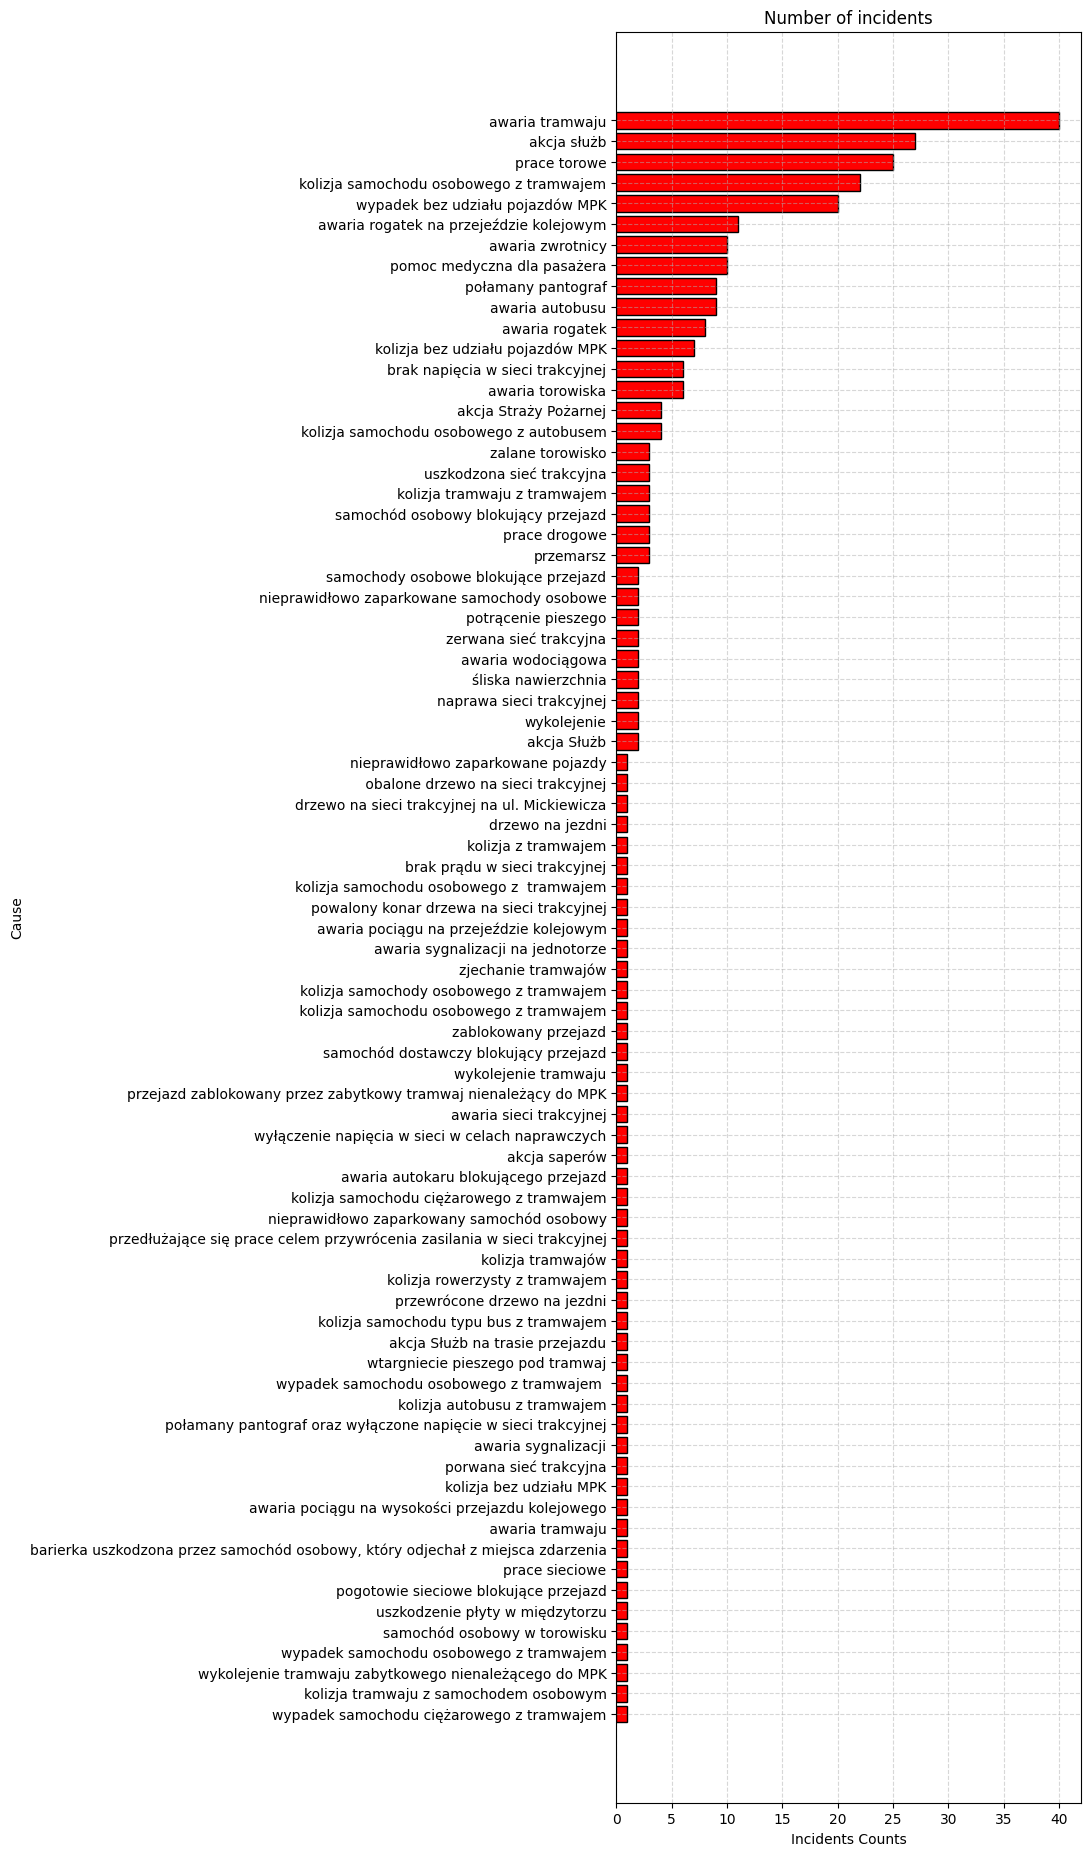

In [51]:
for i, tweet in enumerate(tweets_array, 1):
       print(f"{i}. {tweet[3]} | {tweet[0]} | {tweet[2]} | {tweet[5]} | {tweet[4]} | {tweet[6]}") 
    
incident_counts = {'TRAM': 0, 'BUS': 0, 'Unspecified': 0}
alert_types = {'Incident': 0, 'Re-routing': 0, 'Restoring traffic': 0, "Unspecified": 0}
number_counts = {}
street_counts = {}
causes_counts = {}

for i, tweet in enumerate(tweets_array, 1):
    if tweet[3] == "⚠️":
        alert_types['Incident'] += 1
        
        if tweet[2] == "TRAM":
            incident_counts['TRAM'] += 1
        elif tweet[2] == "BUS":
            incident_counts['BUS'] += 1
        else:
            incident_counts['ND'] += 1
                
        numbers = tweet[5].split(", ")
        for number in numbers:
            if number in number_counts:
                number_counts[number] += 1
            else:
                number_counts[number] = 1
        
        if tweet[4] != '-':
            if tweet[4] in street_counts:
                street_counts[tweet[4]] += 1
            else:
                street_counts[tweet[4]] = 1
        
        if tweet[6] != '-':
            if tweet[6] in causes_counts:
                causes_counts[tweet[6]] += 1
            else:
                causes_counts[tweet[6]] = 1
        
    elif tweet[3] == "🔀":
        alert_types['Re-routing'] += 1
    elif tweet[3] == "↩️":
        alert_types['Restoring traffic'] += 1
    else:
        alert_types['Unspecified'] += 1
                
labels = list(incident_counts.keys())
counts = list(incident_counts.values())
colors = ['blue' if label == 'TRAM' else 'gold' for label in labels]

plt.grid(True, linestyle='--', alpha=0.5)
plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xlabel('Vehicle involved')
plt.ylabel('Count')
plt.title('Total number of incidents')
plt.show()


labels = list(alert_types.keys())
counts = list(alert_types.values())
colors = ['red' if label == 'Incident' else 
          'green' if label == 'Restoring traffic' else 
          'lightblue' if label == 'Re-routing' else
          'gray' for label in labels]

plt.grid(True, linestyle='--', alpha=0.5)
plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xlabel('Alert type')
plt.ylabel('Counts')
plt.title('Total number of alerts')
plt.show()


numbers_list = [(digit, number_counts[digit]) for digit in number_counts]
numbers_list = [item for item in numbers_list if item[0] != '-']
sorted_numbers = sorted(numbers_list, key=lambda x: x[1])
x_values = [item[0] for item in sorted_numbers]
y_values = [item[1] for item in sorted_numbers]
colors = ['blue' if (x.isdigit() and int(x) in range(1, 100) or x in ['T1', 'T2', 'T3', 'T4']) else 'gold' for x in x_values]

plt.figure(figsize=(10,17))
bars = plt.barh(x_values[:len(colors)], y_values[:len(colors)], color=colors, height=0.8, edgecolor='black', linewidth=1.2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Incidents Counts')
plt.ylabel('Line Number')
legend_handles = [plt.Rectangle((0,0),1,1, color='blue'), plt.Rectangle((0,0),1,1, color='gold')]
plt.legend(legend_handles, ['Trams', 'Buses'])
plt.title('Number of incidents')
plt.show()


street_list = [(digit, street_counts[digit]) for digit in street_counts]
sorted_streets = sorted(street_list, key=lambda x: x[1])  
x_values = [item[0] for item in sorted_streets]
y_values = [item[1] for item in sorted_streets]

plt.figure(figsize=(6,36))
plt.barh(x_values, y_values, color='red', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Incidents Counts')
plt.ylabel('Street Name')
plt.title('Number of incidents')
plt.show()


causes_list = [(digit, causes_counts[digit]) for digit in causes_counts]
causes_streets = sorted(causes_list, key=lambda x: x[1])  
x_values = [item[0] for item in causes_streets]
y_values = [item[1] for item in causes_streets]

plt.figure(figsize=(6,23))
plt.barh(x_values, y_values, color='red', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Incidents Counts')
plt.ylabel('Cause')
plt.title('Number of incidents')
plt.show()